In [1]:
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from collections import Counter

# nltk.download('stopwords')
# nltk.download('punkt_tab')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger_eng')

stopwords = set(nltk.corpus.stopwords.words('english'))

In [2]:
# Dataset source: https://www.kaggle.com/datasets/vishakhdapat/imdb-movie-reviews/data
df = pd.read_csv('Dataset/IMDB Dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df.head(30)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [5]:
df['sentiment'].value_counts(normalize=True)

sentiment
positive    0.5
negative    0.5
Name: proportion, dtype: float64

In [6]:
def preprocess_text(text: str):
    # 1. Convert text to lowercase
    def to_lower(text: str):
        return text.lower()

    # 2. Remove punctuation and numbers
    def remove_punctuation_numbers(text: str):
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'\b(\d+)(st|nd|rd|th)\b', '', text)  # Remove Ordered Numbering
        return text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation

    # 3. Tokenize text into words
    def tokenize(text: str):
        return word_tokenize(text)

    # 4. Remove stopwords (common words with little meaning)
    def remove_stopwords(tokens):
        return [word for word in tokens if word not in stopwords]

    # 5. Apply lemmatization (or stemming)
    lemmatizer = WordNetLemmatizer()
    def apply_lemmatization(tokens):
        return [lemmatizer.lemmatize(word) for word in tokens]

    text = to_lower(text)
    text = remove_punctuation_numbers(text)
    tokens = tokenize(text)
    tokens = remove_stopwords(tokens)
    tokens = apply_lemmatization(tokens)
    return " ".join(tokens)

In [7]:
# Preprocess all text here.
df['review'] = df['review'].apply(preprocess_text)

In [8]:
# Encode positive negative sentiments to 0 1
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

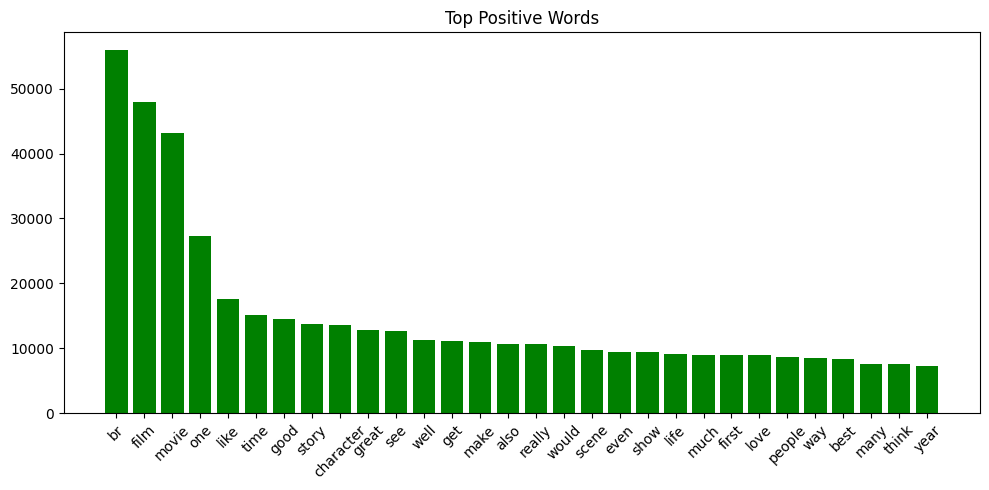

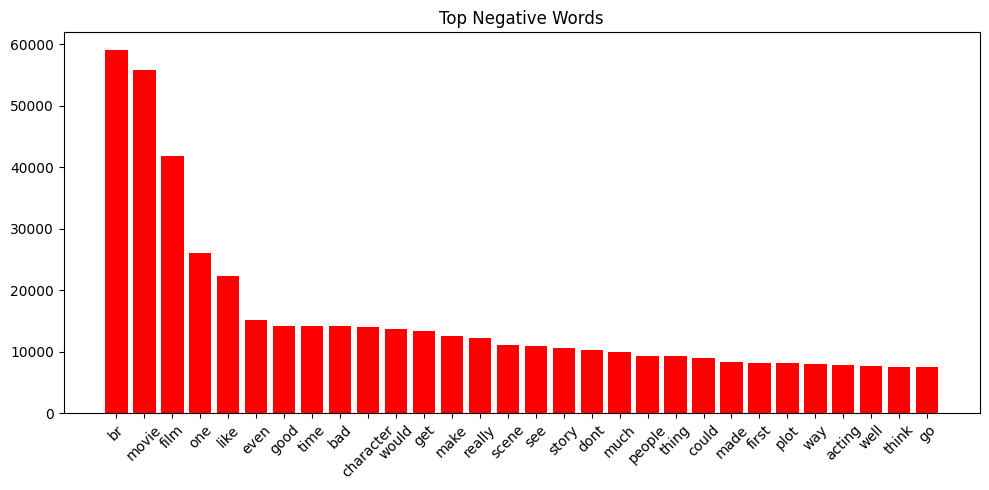

In [42]:
# Bonus
# Visualizing the most frequent words in positive / negative sentiments

positive_texts = df[df['sentiment'] == 1]['review']
negative_texts = df[df['sentiment'] == 0]['review']

positive_words_counter = Counter()
negative_words_counter = Counter()

for review in positive_texts:
    positive_words_counter.update(word_tokenize(review))

for review in negative_texts:
    negative_words_counter.update(word_tokenize(review))

def plot_words(freq_data, title, color):
    words, counts = zip(*freq_data)
    plt.figure(figsize=(10,5))
    plt.bar(words, counts, color=color)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_words(positive_words_counter.most_common(30), 'Top Positive Words', 'green')
plot_words(negative_words_counter.most_common(30), 'Top Negative Words', 'red')

In [9]:
# Extract Features
tfidf = TfidfVectorizer(ngram_range=(1, 2))
x = tfidf.fit_transform(df['review'])
y = df['sentiment'].values

In [10]:
print(x.shape)
print(y.shape)

(50000, 3179456)
(50000,)


In [11]:
x_train, x_test, y_train, y_test = tts(x, y, test_size=0.8, stratify=y, random_state=42)

In [12]:
param_grid = [
    {
        'penalty': ['l1'],
        'solver': ['liblinear', 'saga'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'max_iter': [300, 1000]
    },
    {
        'penalty': ['l2'],
        'solver': ['liblinear', 'saga'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'max_iter': [300, 1000]
    },
    {
        'penalty': ['elasticnet'],
        'solver': ['saga'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9],
        'max_iter': [300, 1000]
    },
    {
        'penalty': ['none'],
        'solver': ['saga'],
        'max_iter': [300, 1000]
    }
]


In [13]:
grid_search_logreg = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search_logreg.fit(x_train, y_train)

y_pred_train_logreg = grid_search_logreg.predict(x_train)
y_pred_test_logreg = grid_search_logreg.predict(x_test)

Fitting 5 folds for each of 98 candidates, totalling 490 fits


C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 490.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "C:\Users\mahmo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.p

In [14]:
print(f"Grid search complete...Best params: {grid_search_logreg.best_params_}")
print(f"Classification Report on train data:\n{classification_report(y_train, grid_search_logreg.predict(x_train))}")
print(f"Classification Report on train data:\n{classification_report(y_test, grid_search_logreg.predict(x_test))}")

Grid search complete...Best params: {'C': 10, 'max_iter': 300, 'penalty': 'l2', 'solver': 'liblinear'}
Classification Report on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Classification Report on train data:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     20000
           1       0.87      0.89      0.88     20000

    accuracy                           0.88     40000
   macro avg       0.88      0.88      0.88     40000
weighted avg       0.88      0.88      0.88     40000



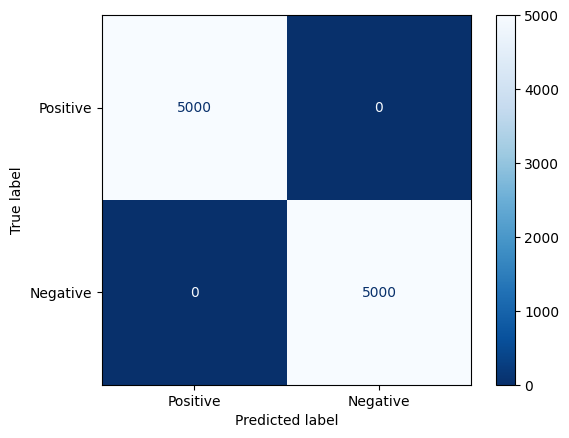

In [31]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_logreg), display_labels=['Positive', 'Negative']).plot(cmap='Blues_r')
plt.show()

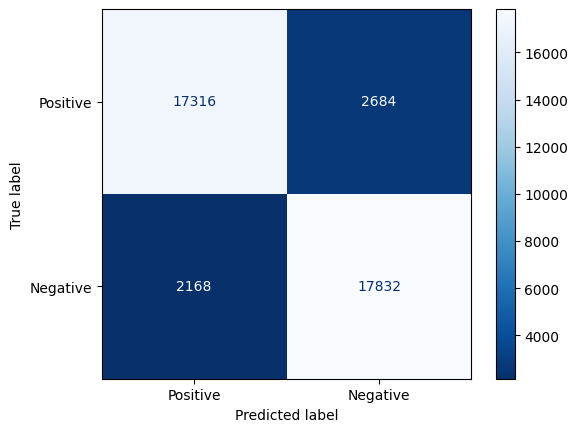

In [30]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_test_logreg), display_labels=['Positive', 'Negative']).plot(cmap='Blues_r')
plt.show()

In [17]:
# Bonus
# Trying naivebayes algorithm

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(
    estimator=MultinomialNB(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

y_pred_train_nb = grid_search.predict(x_train)
y_pred_test_nb = grid_search.predict(x_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [18]:
print(f"Grid search complete...Best params: {grid_search.best_params_}")
print(f"Classification Report on train data:\n{classification_report(y_train, grid_search.predict(x_train))}")
print(f"Classification Report on train data:\n{classification_report(y_test, grid_search.predict(x_test))}")

Grid search complete...Best params: {'alpha': 0.5, 'fit_prior': True}
Classification Report on train data:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000

Classification Report on train data:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     20000
           1       0.89      0.85      0.87     20000

    accuracy                           0.87     40000
   macro avg       0.87      0.87      0.87     40000
weighted avg       0.87      0.87      0.87     40000



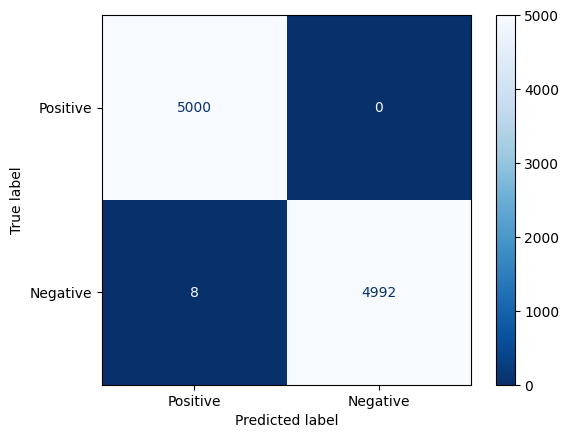

In [29]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, y_pred_train_nb), display_labels=['Positive', 'Negative']).plot(cmap='Blues_r')
plt.show()

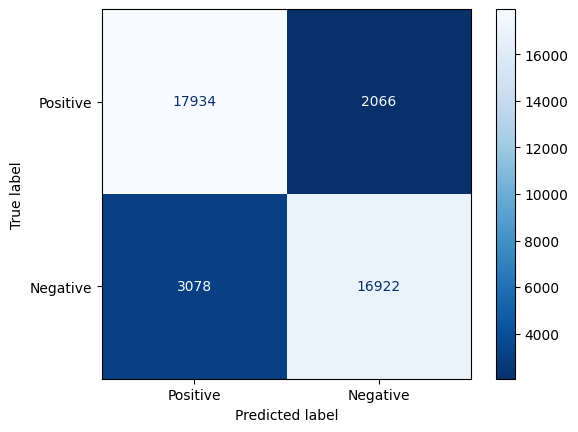

In [28]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_test_nb), display_labels=['Positive', 'Negative']).plot(cmap='Blues_r')
plt.show()

In [44]:
from joblib import dump

dump(grid_search_logreg, 'Saved Models/GridSearchforLogisticRegression.pkl')
dump(grid_search, 'Saved Models/GridSearchforMultinomialNaiveBayes.pkl')
dump(tfidf, 'Saved Models/ReviewTfidf.pkl')
dump(le, 'Saved Models/SentimentLabelEncoder.pkl')
print('Done!')

Done!
